In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image

In [9]:
model = torch.load("models/xxx.pth", map_location="cpu")

In [13]:
def draw_boxes(img, boxes):

    fig, ax = plt.subplots(figsize=(12, 9))

    ax.imshow(img)

    for box in boxes:
        x0, y0, x1, y1 = box[0], box[1], box[2], box[3]
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), w, h, linewidth=3, edgecolor="orange", facecolor="none")
        ax.add_patch(rect)

    plt.show()


def evaluate(image_path, detector, num_boxes):
    img = Image.open(image_path).resize((300, 300))

    x = transforms.ToTensor()(img)
    x = x.unsqueeze(0)
    
    detector.eval()

    with torch.no_grad():
        output = model(x)[0]
        boxes  = output["boxes"]
        scores = output["scores"]
        boxes  = boxes[:num_boxes]

    draw_boxes(img, boxes)

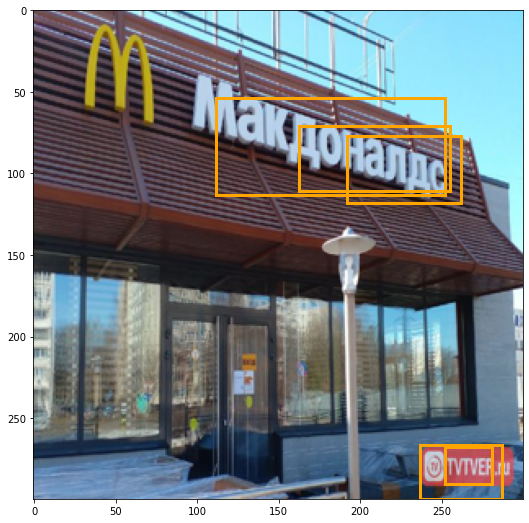

In [15]:
evaluate("data/mcdonlands.jpg", model, num_boxes=5)